### Import Libraries

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image 

### Change Path to Working Directory

In [12]:
import os
print("Current working directory:", os.getcwd())
os.chdir(r"D:\Labmentix\Aerial-Object-Detection-Bird-vs-Drone")
print("Now in:", os.getcwd())

Current working directory: D:\Labmentix\emipredict_ai
Now in: D:\Labmentix\Aerial-Object-Detection-Bird-vs-Drone


### Define dataset parameters


In [13]:
image_height = 224
image_width = 224
num_channels = 3
batch_size = 32
num_classes = 2

### Get Image From each Directory ( Visualization)


In [17]:
data_path=r'data/dataset'
image_classes = os.listdir(data_path)
print(image_classes)

['bird', 'drone']


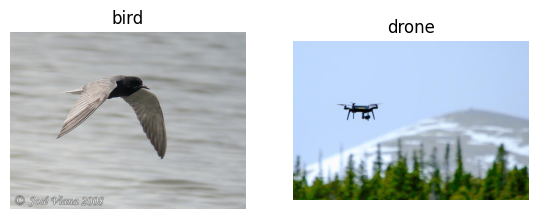

In [18]:
def plot_image(image_classes):
    plt.figure(figsize=(14 , 14))
    
    for i , category in enumerate(image_classes):
        image_path = data_path + '/' + category
        images_in_folder = os.listdir(image_path)
        
        first_image = images_in_folder[0]
        first_image_path = image_path + '/' + first_image 
        
        img= image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255
        
        plt.subplot(4 , 4 , i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()
plot_image(image_classes)

In [19]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split for training and validation
)

### Preprocessing Data & Split Data into Train & Test


In [20]:
train_data = train_datagen.flow_from_directory(
    r'dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

Found 3284 images belonging to 2 classes.


In [21]:
val_data = train_datagen.flow_from_directory(
    r'dataset',  
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 820 images belonging to 2 classes.


### Load the pre-trained MobileNetV2 model


In [22]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


In [23]:
#Freeze the base model's layers to retain pre-trained weights
base_model.trainable = False

# Build the model

In [24]:
model = Sequential([
    base_model,  # Add the pre-trained model as the base
    GlobalAveragePooling2D(),  # Add a pooling layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.3),  # Dropout for regularization
    Dense(num_classes, activation='softmax')  # Output layer
])

### Compile the Model


In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Callbacks

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

### Train the Model


In [27]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 394s 4s/step - accuracy: 0.9290 - loss: 0.1891 - val_accuracy: 0.8780 - val_loss: 0.3204 - learning_rate: 0.0010
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 855s 8s/step - accuracy: 0.9686 - loss: 0.0903 - val_accuracy: 0.9171 - val_loss: 0.2332 - learning_rate: 0.0010
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.9711 - loss: 0.0783 - val_accuracy: 0.9329 - val_loss: 0.1902 - learning_rate: 0.0010
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.9744 - loss: 0.0645 - val_accuracy: 0.9305 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9772 - loss: 0.0582 - val_accuracy: 0.9293 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9802 - loss: 0.0527 - val_accuracy: 0.9220 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.9857 - loss: 0.

### Evaluate The Model Accuracy & Visualize Results

In [28]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9171 - loss: 0.2101
Validation Loss: 0.21014802157878876
Validation Accuracy: 0.9170731902122498


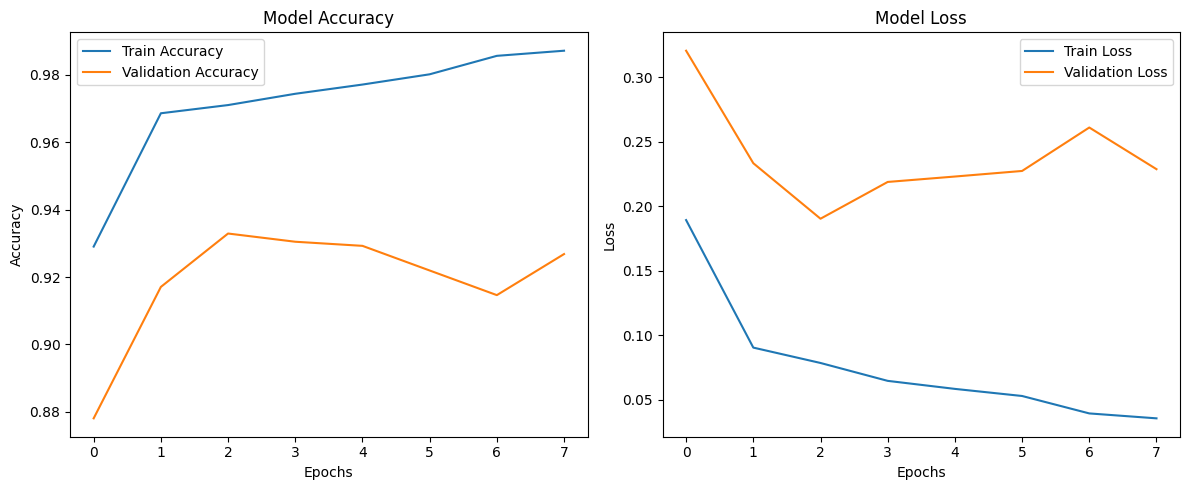

In [29]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

### Save Model as h5

In [31]:
# Save the final trained model
model.save("models/mobilenet_bird_drone_classifier.keras")